In [34]:
import random
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
import seaborn as sns
import itertools
import pickle
import math
import networkx as nx
import community
import pickle 
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
from operator import itemgetter
from fa2 import ForceAtlas2
sns.set()
%matplotlib inline

In [35]:
# Getting the ForceAtlas algorithm configuration ready

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = False, # Dissuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.2, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5,
    strongGravityMode=True,
    gravity=1.0,
    
    # Log
    verbose=False
)

# Hugmyndir og tékk listi


#### Must do: 
Wordclouds sem eru í laginu eins og characterinn fyrir top 10 characerana (flestar línur)

Network fyrir hverja mynd byggt á hversu oft karakterar eru saman í senu

Network fyrir hverja mynd með því að taka karaktera sem tala á undan hvorum öðrum (notað í stað línunar á undan), hér væri þá counter á milli karaktera ef þér koma í röð á eftir hvorum öðrum. 

Sentiment analysis á Karakterana og myndirnar, 

Almenn statistic um myndirnar, karakterar, sentimen....


--------------
#### Advanced hugmyndir:
Gera svona transition network (einskonar race graph) þar sem networkið byggir á síðustu 500 setningnum og sýnir hverjir eru að tala mest saman í gegnum allar myndirnar.



PUnktar sem ég hafði upphaflega....
Skoða sentiment á setningum komið

SKoða sentiment á scenes komið 

SKoða sentiment sérstakra karaktera  komið

Skoða tengst karaktera m.v. scene eða röðun (fyrir og eftir), ef character kemur fyrir og eftir þá tala þeir sama t.d.

Create wordclous out of sentences with the outlines of the characters

Create a quiz where you get a sentence from character and guess who it was.

In [36]:
# Read in the dataframe
import pickle
import pandas as pd
import numpy as np

df = pd.read_pickle("script_df.pkl")
df.head()

,movie_nr,sentence_number,character,sentence,scene_desc,scene_id
0,1,1,Dumbledore,I should have known that you would be here...P...,A neighbourhood on a street called Privet Driv...,1
1,1,2,McGonagall,"Good evening, Professor Dumbledore. Are the ru...","The cat meows, sniffs out and the camera pans ...",1
2,1,3,Dumbledore,"I'm afraid so, Professor. The good, and the bad.","The cat meows, sniffs out and the camera pans ...",1
3,1,4,McGonagall,And the boy?,"The cat meows, sniffs out and the camera pans ...",1
4,1,5,Dumbledore,Hagrid is bringing him.,"The cat meows, sniffs out and the camera pans ...",1


# Cleaning the dataframe:

In [37]:
# All the movie titles in correct order
movie_titles = ["Harry Potter and the Philosopher's Stone","Harry Potter and the Chamber of Secrets",
              "Harry Potter and the Prisoner of Azkaban","Harry Potter and the Goblet of Fire",
              "Harry Potter and the Order of the Phoenix","Harry Potter and the Half-Blood Prince",
              "Harry Potter and the Deathly Hallows – Part 1","Harry Potter and the Deathly Hallows – Part 2"]
movie_titles_short = [movie_titles[i].split("Harry Potter and the ", 1)[1] for i in range(len(movie_titles))]

In [38]:

#  Split on all character names that include / to give each character its own line even though many are saying the sentence at once
# symbols = ['/',' --- ','']
# for symbol in symbols:
df = df.drop('character', axis=1).join(df['character'].str.split('/', expand=True).stack().reset_index(level=1, drop=True).rename('character'))
df.character = df.character.str.strip()

df = df[['movie_nr', 'sentence_number', 'character', 'sentence', 'scene_desc', 'scene_id']]

In [39]:
# Lets first fix the characters So they all have lower_case letters
df['character'] = df['character'].str.lower()

In [40]:
# Throw out where character names include some words
throw_out_list = ['new','same','moving',' you ']
for throw in throw_out_list:
    df = df[~df.character.str.contains(throw)]
    

# TODO, clean all characters that have more than 4 word, len(str.split) > 4
df = df[df.character.str.split(' ').apply(len)<4]

In [41]:
# df[df.sentence != ''].groupby('character').size()
# sentence_count = df[df.sentence != ''].groupby('character').size()
# sentence_count_limit = sentence_count[sentence_count > 2]

map_characters = {'dumbledore': 'albus dumbledore',
                  'dumbledore (cont’d)': 'albus dumbledore',
                  'tom riddle': 'voldemort',
                  'riddle': 'voldemort',
                  'voldermort': 'voldemort',
                  'harry': 'harry potter',
                 'lucius': 'lucius malfoy',
                 'draco': 'draco malfoy',
                 'malfoy': 'draco malfoy'}

df.character = df.character.map(map_characters).fillna(df['character'])
# df.character = df.character.replace(map_characters)

#  Now when all names have been mapped and fixed we capitalize the names for cleaner representation 
df.character = df.character.str.title() 

In [42]:
df.to_pickle("./movie_scripts.pkl")

# Enrich the dataframe with sentiment analysis

### Create dictionary of character and movie sentences

In [43]:
# Add new column to dataframe that include the tokenized sentences
# Function to calculate the sentiment of tokenized list
def tokenize(text):
    #toxenize the text 
    tokens = nltk.word_tokenize(text)
    words = [w.lower() for w in tokens if w.isalpha()]
    lem_words = [wnl.lemmatize(w) for w in words if w not in stopwords]
    return(lem_words)

stopwords = nltk.corpus.stopwords.words('english')
wnl = nltk.WordNetLemmatizer()

In [44]:
# Lets combine all sentences of characters into a dictionary

char_sentences = dict()
for character in df.character.unique():
    text = tokenize(df.sentence[df.character == character].str.cat(sep=' '))
    char_sentences[character] = text
    
# Lets combine all sentences for each movie into a dictionary
movie_sentences = dict()
for movie in df.movie_nr.unique():
    text = tokenize(df.sentence[df.movie_nr == movie].str.cat(sep=' '))
    movie_sentences[movie] = text
    
# maybe have dictionary that has the key movie, that has the key of character and and the value as sentence

In [45]:
nltk.FreqDist(movie_sentences[1])

FreqDist({'harry': 161, 'go': 59, 'see': 53, 'come': 50, 'ron': 50, 'one': 49, 'oh': 48, 'know': 47, 'hagrid': 44, 'potter': 39, ...})

In [46]:
# Read in the sentiment text file
import csv
sentiments = {}
with open('data/Data_Set_S1.txt', 'r') as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in reader:
        if len(row) == 8 and row[0] != "word": # skipping the first lines
            sentiments[row[0].lower()] = float(row[2]) # storing the average sentiment

In [47]:
# Function to calculate the average sentiment for each characters 
def sentiment(freqdist,cut_off=False):
    sentim_words = [w for w in freqdist.keys() if sentiments.get(w)] # get all word that are in sentiment list
    sentim_values = [sentiments[val]*freqdist[val] for val in sentim_words] # get the value and multiplay by frequency
    sentim_words_freq = sum([freqdist[w] for w in sentim_words]) # total occurances of all valid sentim words
    if cut_off:
        if sentim_words_freq > cut_off: # only take in words that have certin frequency of sentimental words
            return sum(sentim_values) / sentim_words_freq
        else: 
            return None
    else:
        if len(sentim_words) > 0:
            return sum(sentim_values) / sentim_words_freq
        else: 
            return None

In [48]:
# Get average sentiment for all sentences of character
char_sentiment = {}
for char in char_sentences:
    sentiment_for_char = sentiment(nltk.FreqDist(char_sentences[char]))
    if sentiment_for_char:
        char_sentiment[char] = sentiment_for_char
        
# Get average sentiment for all sentences of character
movie_sentiment = {}
for movie in movie_sentences:
    sentiment_for_movie = sentiment(nltk.FreqDist(movie_sentences[movie]))
    if sentiment_for_movie:
        movie_sentiment[movie] = sentiment_for_movie

In [49]:
# Function to calculate the sentiment of tokenized list
def token_getsent(text):
    #lets toxenize the text 
    tokens = nltk.word_tokenize(text)
    words = [w.lower() for w in tokens if w.isalpha()]
    lem_words = [wnl.lemmatize(w) for w in words if w not in stopwords]
    
    # Get the sentiment score
    return(sentiment(nltk.FreqDist(lem_words)))
    

# Add the sentiment for all scenes and sentences
df['sentence_sent'] = df.apply(lambda x: token_getsent(x['sentence']),axis=1)
df['scene_desc_sent'] = df.apply(lambda x: token_getsent(x['sentence']),axis=1)

# lets add the average sentence sentiment for each scene_id
df['avg_scene_sent'] = df.groupby(['scene_id'])['sentence_sent'].transform('mean')
df['avg_scene_desc_sent'] = df.groupby(['scene_id'])['scene_desc_sent'].transform('mean')

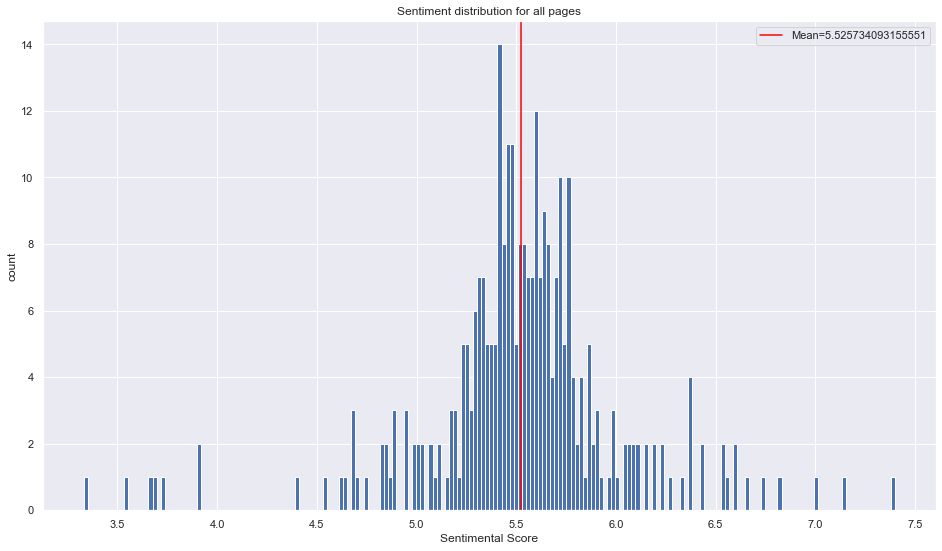

In [50]:
#Create a histogram of all character's associated page-sentiments.
import numpy as np 

plt.figure(figsize=(16,9))
plt.hist(char_sentiment.values(),bins=200)
sent_mean = np.mean((list(char_sentiment.values())))
plt.axvline(x=sent_mean, label=f'Mean={sent_mean}', c='red')
plt.legend()
plt.title('Sentiment distribution for all pages')
plt.ylabel('count')
plt.xlabel('Sentimental Score')

plt.show()

In [52]:
df.to_pickle("./movie_scripts.pkl")

Now we only want to look at characters that have certain amount of sentences or words that actually compount to a meaninful sentiment analysis. To do this the limit of words needed is set to be 25, that is 25 words that have a sentiment rating needs to be said by a character to be considered in the following sentiment analysis.

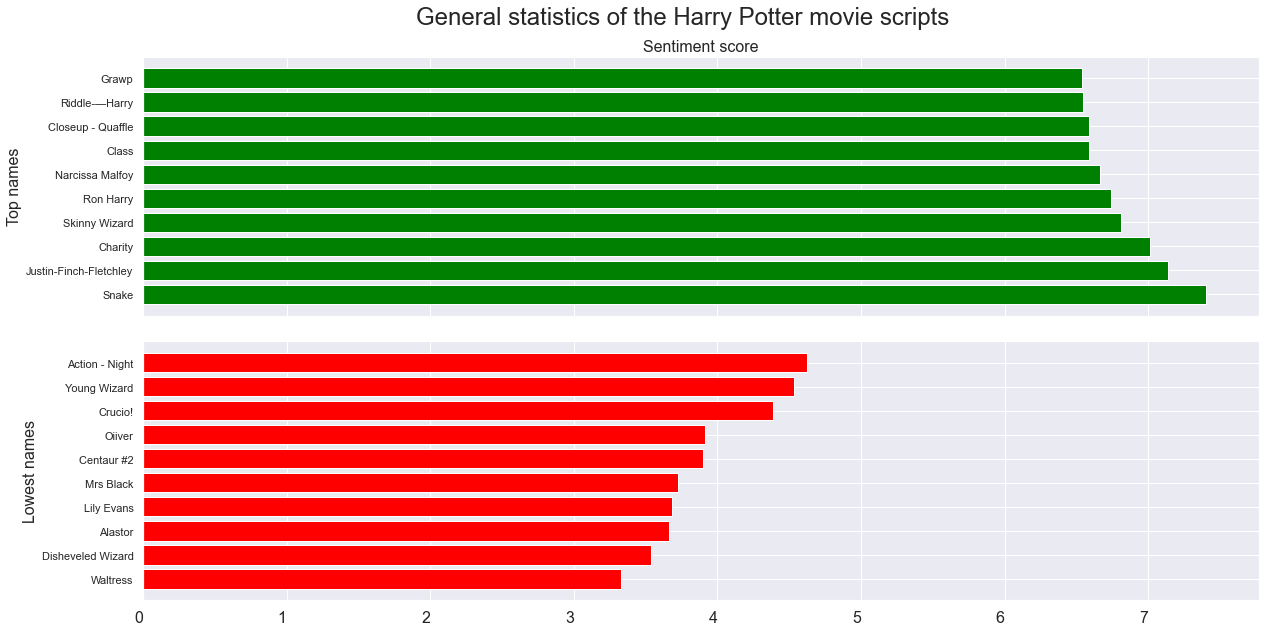

In [80]:
# Top 10 lowest and highest sentiment characters
best_name = sorted(char_sentiment, key=char_sentiment.get, reverse=False)[:10]
best_sent = [char_sentiment[x] for x in best_name]

worst = sorted(char_sentiment, key=char_sentiment.get, reverse=True)[:10]
worst_sent = [char_sentiment[x] for x in worst]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(20,10), gridspec_kw={'hspace': 0.1})

axes[0].barh(worst, worst_sent, color='green')
axes[0].set_title('Sentiment score', fontsize=16)
axes[0].set_ylabel('Top names', fontsize=16)

axes[1].barh(best_name, best_sent, color='red')
# axes[1].set_title('Sentiment score', fontsize=16)
axes[1].set_ylabel('Lowest names', fontsize=16)

# Set the rotation and horizontal alignment of the x tick labels
plt.setp(axes[0].get_xticklabels(), ha="left", fontsize=16);
plt.setp(axes[1].get_xticklabels(), ha="right", fontsize=16);

# Set plot title
plt.suptitle('General statistics of the Harry Potter movie scripts', fontsize=24, y = 0.95);

In [ ]:
#  TODO Create subplot with 7 figures and top 10 characters and their sentence count

#  Top 10 characters in each movie
# names = df['character'].value_counts()[:10].index
df.head()

## General statistics about the script data set:

### Creating count for various properties of the scripts

In [ ]:
# Sentence count, that is the highset sentence number for each movie
sentence_count = []
for movie in df.movie_nr.unique():
    sentence_count.append(df.sentence_number[df.movie_nr == movie].max())
sentence_count

# Scene count
scene_count = []
for movie in df.movie_nr.unique():
    scene_count.append(df.scene_id[df.movie_nr == movie].max())
scene_count

# Character count
character_count = []
for movie in df.movie_nr.unique():
    character_count.append(len(df.character[df.movie_nr == movie].unique()))
# character_count

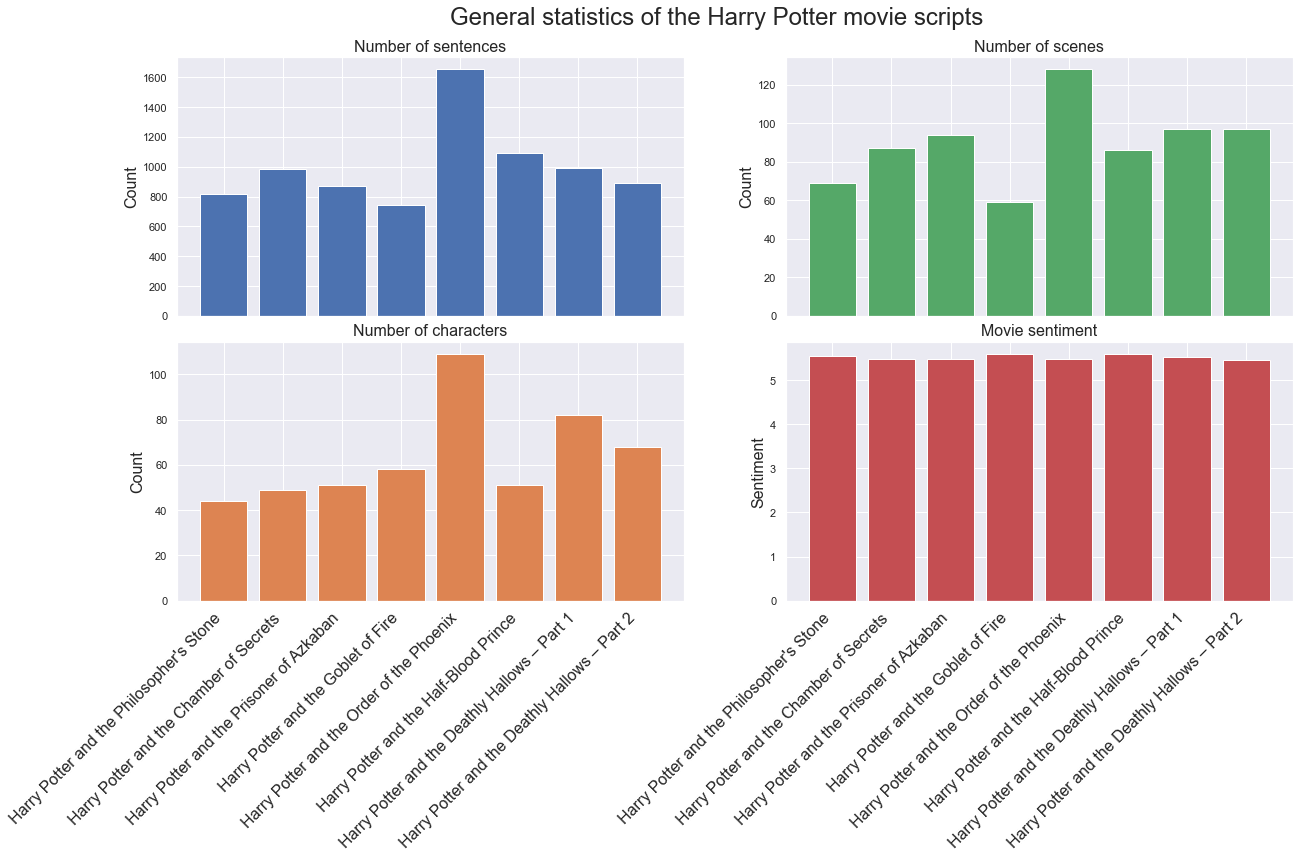

In [32]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(20,10), gridspec_kw={'hspace': 0.1})

palette = itertools.cycle(sns.color_palette())

axes[0][0].bar(movie_titles, sentence_count, width = 0.8, color=next(palette))
axes[0][0].set_title('Number of sentences', fontsize=16)
axes[0][0].set_ylabel('Count', fontsize=16)

axes[1][0].bar(movie_titles, character_count, width = 0.8, color=next(palette))
axes[1][0].set_title('Number of characters', fontsize=16)
axes[1][0].set_ylabel('Count', fontsize=16)

axes[0][1].bar(movie_titles, scene_count, width = 0.8, color=next(palette))
axes[0][1].set_title('Number of scenes', fontsize=16)
axes[0][1].set_ylabel('Count', fontsize=16)

axes[1][1].bar(movie_titles, movie_sentiment.values(), width = 0.8, color=next(palette))
axes[1][1].set_title('Movie sentiment', fontsize=16)
axes[1][1].set_ylabel('Sentiment', fontsize=16)

# Set the rotation and horizontal alignment of the x tick labels
plt.setp(axes[1][0].get_xticklabels(), rotation=45, ha="right", fontsize=16);
plt.setp(axes[1][1].get_xticklabels(), rotation=45, ha="right", fontsize=16);

# Set plot title
plt.suptitle('General statistics of the Harry Potter movie scripts', fontsize=24, y = 0.95);

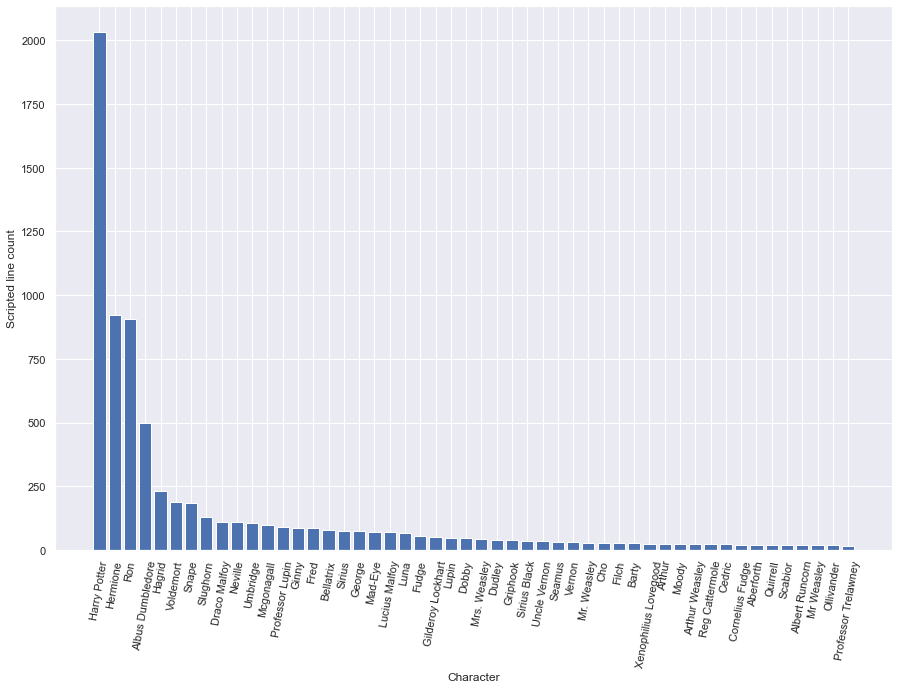

In [33]:
# Look at the top speaking characters and plot the total sentence count 
names = df['character'].value_counts()[:50].index
value = df['character'].value_counts()[:50]
# # Preparing figure
plt.figure(figsize=(15,10))

plt.bar(names,value,width=0.8)
plt.xlabel('Character')
plt.ylabel('Scripted line count')
plt.xticks(rotation=80)
plt.show()

In [83]:
names = df.character[df.movie_nr == 1].value_counts()[:15].index
names

Index(['Harry Potter', 'Ron', 'Hermione', 'Hagrid', 'Mcgonagall',
       'Albus Dumbledore', 'Vernon', 'Quirrell', 'Dudley', 'Neville',
       'Draco Malfoy', 'Hooch', 'Petunia', 'Snape', 'Percy'],
      dtype='object')

# Create character connections based on how many times they in the same scene in the movies

In [84]:
# lets create connection between characters 

# for movie in df.movie_nr:
# movie = 1
# df_names = df['character'].unique()
# df_store = df[df.movie_nr == movie].groupby(['scene_id','movie_nr'])['character'].unique()

scene_interactions = dict()
for movie in df.movie_nr.unique():
    df_store = df[df.movie_nr == movie].groupby(['scene_id'])['character'].unique()
    for scene in df_store:
        for idx in range(len(scene)-1):
            for idx2 in range(idx+1,len(scene)):
                if (scene[idx],scene[idx2]) in scene_interactions:
                    scene_interactions[(scene[idx],scene[idx2])] += 1
                else:
                    if (scene[idx2],scene[idx]) in scene_interactions:
                        scene_interactions[(scene[idx2],scene[idx])] += 1
                    else:
                        scene_interactions[(scene[idx],scene[idx2])] = 1
scene_interactions

{('Albus Dumbledore', 'Mcgonagall'): 5,
 ('Albus Dumbledore', 'Hagrid'): 8,
 ('Albus Dumbledore', 'Petunia'): 1,
 ('Albus Dumbledore', 'Dudley'): 1,
 ('Albus Dumbledore', 'Vernon'): 1,
 ('Albus Dumbledore', 'Harry Potter'): 51,
 ('Mcgonagall', 'Hagrid'): 2,
 ('Mcgonagall', 'Petunia'): 1,
 ('Mcgonagall', 'Dudley'): 1,
 ('Mcgonagall', 'Vernon'): 1,
 ('Mcgonagall', 'Harry Potter'): 19,
 ('Hagrid', 'Petunia'): 2,
 ('Hagrid', 'Dudley'): 2,
 ('Hagrid', 'Vernon'): 2,
 ('Hagrid', 'Harry Potter'): 46,
 ('Petunia', 'Dudley'): 4,
 ('Petunia', 'Vernon'): 7,
 ('Petunia', 'Harry Potter'): 5,
 ('Dudley', 'Vernon'): 6,
 ('Dudley', 'Harry Potter'): 9,
 ('Vernon', 'Harry Potter'): 7,
 ('Dudley', 'Snake'): 1,
 ('Dudley', 'Man'): 1,
 ('Vernon', 'Snake'): 1,
 ('Vernon', 'Man'): 1,
 ('Harry Potter', 'Snake'): 1,
 ('Harry Potter', 'Man'): 7,
 ('Snake', 'Man'): 1,
 ('Snake', 'Petunia'): 1,
 ('Man', 'Petunia'): 1,
 ('Harry Potter', 'All'): 4,
 ('Vernon', 'All'): 1,
 ('Hagrid', 'All'): 3,
 ('Petunia', 'All'): 1

In [ ]:
#  Lets create a graph based on how many times a character says another characters name

#  TODO

In [85]:
G = nx.Graph()
# G.add_edge((2, 3, {'weight': 3.1415}))

G.add_edges_from([(2, 3, {'weight': 3.1415})])

# Create an undirected weighted graph
G = nx.Graph()
for edge in scene_interactions:
    edge_1 = edge[0]
    edge_2 = edge[1]
    weight = scene_interactions[edge]
    G.add_edges_from([(edge_1, edge_2, {'weight': weight})])


In [90]:
# Extracting the GCC
G_GCC = G.subgraph(max(nx.connected_components(G), key=len))

partition = community.best_partition(G_GCC, random_state = 0)

In [91]:
# Create a dictionary of node name and community number
communities = {}
for node in G_GCC.nodes:
    communities[node] = partition[node]
        
# Get all the community values in a single variable for counting
lovain_communities = communities.values()  

# Count and sort the communities
communities_counter = Counter(lovain_communities).most_common(max(lovain_communities))

# Add the community numbers to an attribute within the graph
nx.set_node_attributes(G_GCC, communities, "community")

# Print a single hero to see that this worked
#print(G.nodes['Rubeus Hagrid']['community'])

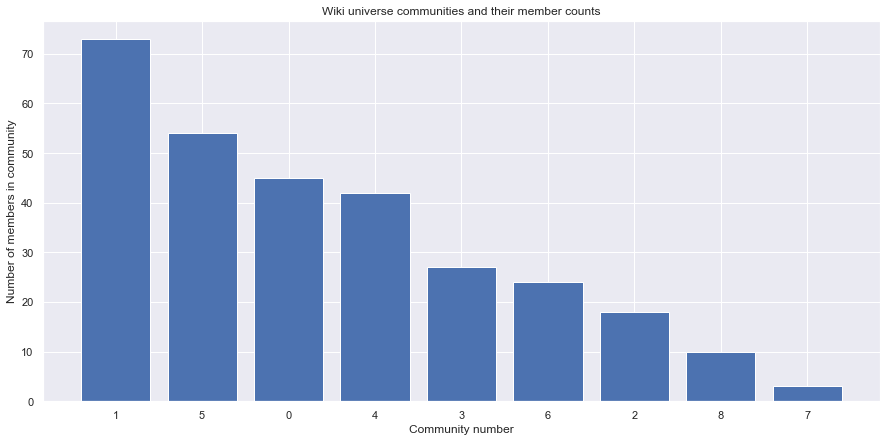

In [92]:
# Lets plot the communities and see how many are in each one
plt.figure(figsize = (15,7))

labels, values = zip(*communities_counter)
indexes = np.arange(len(labels))

plt.bar(indexes, values)
plt.xticks(indexes, labels)
plt.xlabel('Community number')
plt.ylabel('Number of members in community')
plt.title('Wiki universe communities and their member counts')
plt.show()

In [93]:
# Generate the numbers of the top 10 communities and top 6 communities
top_10_communities = [el[0] for el in Counter(lovain_communities).most_common(10)]

# Let's find out the 'biggest' nodes
nodes = dict(sorted(nx.degree_centrality(G_GCC).items(), key = itemgetter(1), reverse = True)[0:10])
top_nodes = list(nodes.keys())

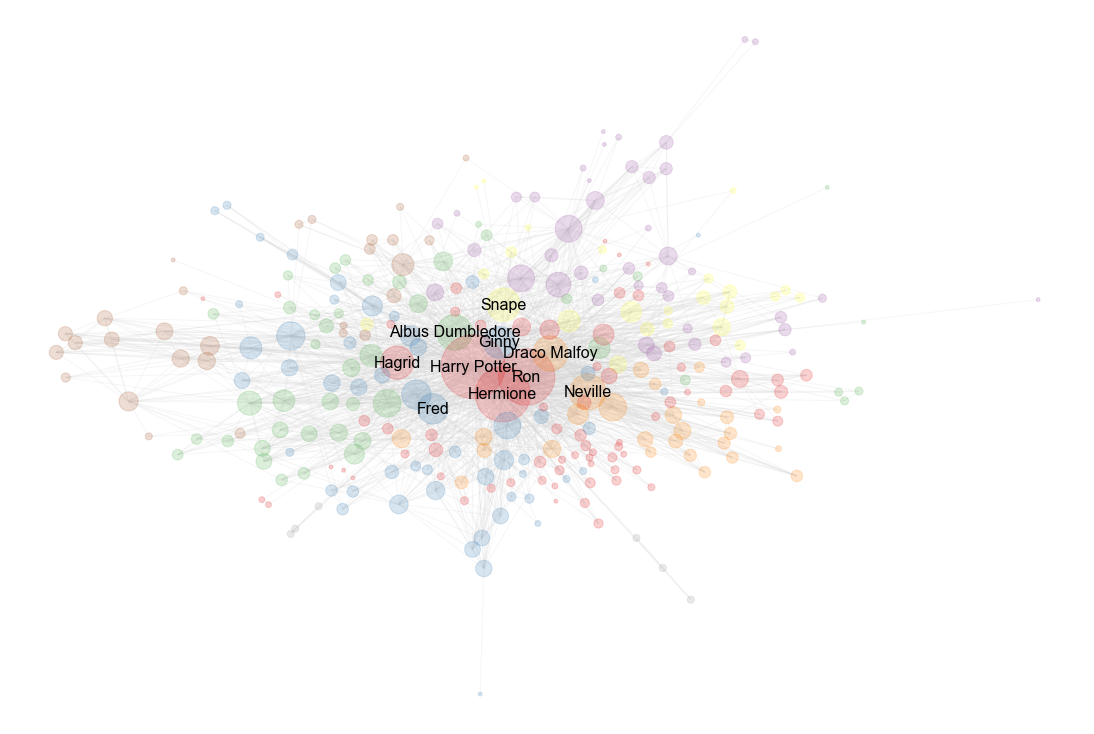

In [94]:
# Finally lets plot these results on the undirected version of the graph - NOTE HERE WE USE UNDIRECTED FOR PLOTTING
import matplotlib as mtpl
from fa2 import ForceAtlas2

cmap = mtpl.cm.get_cmap('Set1', 10) # create 10 colors to use for plotting

colors = []

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(mtpl.colors.rgb2hex(rgb))


plt.figure(figsize=(15,10))

forceatlas3 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = True, # Persuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.7, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5.0,
    strongGravityMode=True,
    gravity=50.0,
    
    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(G_GCC, pos=None, iterations=2000)

# Generate sizes based on node centrality
node_sizes = list(nx.degree_centrality(G_GCC).values())
node_sizes = [round(num,3) for num in node_sizes]
node_sizes = [num*5000 for num in node_sizes]

# Lets try only coloring in the 10 biggest communities - other minor communities will be gray
# Otherwise it gets to confusing
node_colors = [colors[top_10_communities.index(m)] if (m in top_10_communities) else '#808080' for m in lovain_communities]

# Generate the graph
nx.draw(G_GCC, positions, with_labels = False, node_size = node_sizes, 
        node_color = node_colors, edge_color = 'lightgray', alpha=0.2);

# Generate the labels
labels = {}    
for node in G_GCC.nodes():
    if node in top_nodes[:10]:
        #set the node name as the key and the label as its value 
        labels[node] = node

# Now draw only the labels of the top nodes
nx.draw_networkx_labels(G_GCC, positions, labels, font_size=16, font_color='black');

In [95]:
top_10 = sorted(scene_interactions, key=scene_interactions.get, reverse=True)[:10]

# scene_interactions[top_10]
# top_10
# top_list = []
# for pair in top_10:
#     top_list.append(scene_interactions[pair])

dict_you_want = { your_key: scene_interactions[your_key] for your_key in top_10 }
dict_you_want

{('Ron', 'Harry Potter'): 233,
 ('Harry Potter', 'Hermione'): 213,
 ('Ron', 'Hermione'): 181,
 ('Albus Dumbledore', 'Harry Potter'): 51,
 ('Hagrid', 'Harry Potter'): 46,
 ('Neville', 'Harry Potter'): 35,
 ('Neville', 'Ron'): 29,
 ('Harry Potter', 'Ginny'): 29,
 ('Draco Malfoy', 'Harry Potter'): 28,
 ('George', 'Fred'): 27}

### Trying different method of interaction

In [116]:
test = []

if test:
    print('yes')

In [117]:
#  Count mentions between characters
char_list = df.character.str.lower().unique()

ref_connection = {}

for char in char_list:
    df_slice = df[df.character.str.lower() != char]
    ref_list = list(df_slice.character[df_slice.sentence.str.contains(char)])
    if ref_list:
        ref_connection[char] = ref_list
ref_connection

{'harry potter': ['Luna'],
 'snake': ['Harry Potter',
  'Dudley',
  'Harry Potter',
  'Hermione',
  'Harry Potter',
  'Hermione',
  'Hermione',
  'Ernie',
  'Ron',
  'Gilderoy Lockhart',
  'Gilderoy Lockhart',
  'Harry Potter',
  'Harry Potter',
  'Harry Potter',
  'Harry Potter',
  'Harry Potter',
  'Arthur',
  'Tonks',
  'Snape',
  'Albus Dumbledore',
  'Voldemort',
  'Harry Potter',
  'Ron',
  'Ron',
  'Albus Dumbledore',
  'Harry Potter',
  'Harry Potter',
  'Harry Potter',
  'Hermione'],
 'man': ['Dudley',
  'Vernon',
  'Hagrid',
  'Trainmaster',
  'Fred',
  'Albus Dumbledore',
  'Percy',
  'Snape',
  'Ron',
  'Hooch',
  'Neville',
  'Mcgonagall',
  'Snape',
  'Ron',
  'Harry Potter',
  'Albus Dumbledore',
  'Ron',
  'Filch',
  'Hagrid',
  'Hagrid',
  'Filch',
  'Firenze',
  'Harry Potter',
  'Albus Dumbledore',
  'Harry Potter',
  'Mr. Weasley',
  'Mrs. Weasley',
  'Lucius Malfoy',
  'Colin',
  'Ron',
  'Draco Malfoy',
  'Hermione',
  'Lucius Malfoy',
  'Hagrid',
  'Lucius Malfoy

In [231]:
# lets create connection between characters 

# for movie in df.movie_nr:
# movie = 1
# df_names = df['character'].unique()
# df_store = df[df.movie_nr == movie].groupby(['scene_id','movie_nr'])['character'].unique()

scene_interactions = dict()
for movie in df.movie_nr.unique():
    print(f'Going through movie {movie}')
    df_store = df[df.movie_nr == movie].groupby(['scene_id','movie_nr'])['character'].unique()
    for scene in df_store:
    #     print("Scene length:",len(scene))
        for idx in range(len(scene)-1):
            for idx2 in range(idx+1,len(scene)):
    #             print(scene[idx],scene[idx2])
                if (scene[idx],scene[idx2]) in scene_interactions:
                    scene_interactions[(scene[idx],scene[idx2])] += 1
                else:
                    if (scene[idx2],scene[idx]) in scene_interactions:
                        scene_interactions[(scene[idx2],scene[idx])] += 1
                    else:
                        scene_interactions[(scene[idx],scene[idx2])] = 1
scene_interactions

Going through movie 1
Going through movie 2
Going through movie 3
Going through movie 4
Going through movie 5
Going through movie 6
Going through movie 7
Going through movie 8


{('albus dumbledore', 'mcgonagall'): 5,
 ('albus dumbledore', 'hagrid'): 8,
 ('albus dumbledore', 'petunia'): 1,
 ('albus dumbledore', 'dudley'): 1,
 ('albus dumbledore', 'vernon'): 1,
 ('albus dumbledore', 'harry potter'): 51,
 ('mcgonagall', 'hagrid'): 2,
 ('mcgonagall', 'petunia'): 1,
 ('mcgonagall', 'dudley'): 1,
 ('mcgonagall', 'vernon'): 1,
 ('mcgonagall', 'harry potter'): 19,
 ('hagrid', 'petunia'): 2,
 ('hagrid', 'dudley'): 2,
 ('hagrid', 'vernon'): 2,
 ('hagrid', 'harry potter'): 46,
 ('petunia', 'dudley'): 4,
 ('petunia', 'vernon'): 7,
 ('petunia', 'harry potter'): 5,
 ('dudley', 'vernon'): 6,
 ('dudley', 'harry potter'): 9,
 ('vernon', 'harry potter'): 7,
 ('dudley', 'snake'): 1,
 ('dudley', 'man'): 1,
 ('vernon', 'snake'): 1,
 ('vernon', 'man'): 1,
 ('harry potter', 'snake'): 1,
 ('harry potter', 'man'): 7,
 ('snake', 'man'): 1,
 ('snake', 'petunia'): 1,
 ('man', 'petunia'): 1,
 ('harry potter', 'all'): 4,
 ('vernon', 'all'): 1,
 ('hagrid', 'all'): 3,
 ('petunia', 'all'): 1

In [98]:
dict(sorted(scene_interactions.iteritems(), key=operator.itemgetter(1), reverse=True)[:5])

AttributeError: 'dict' object has no attribute 'iteritems'

In [107]:
dict(sorted(scene_interactions.items(), key=lambda x: x[1]['score'], reverse=True)[:2])

TypeError: 'int' object is not subscriptable

In [96]:
# con_scene_desc = dict()
# for movie in df.movie_nr:
movie = 1
# df_names = df['character'].unique()
df_store = df[df.movie_nr == movie].groupby(['scene_desc','movie_nr'])['character'].unique()

scene_interactions = dict()
for movie in df.movie_nr:
    df_movie = df[df.movie_nr == movie]
    for scene in df_scene:
        for idx in range(len(scene)-1):
            for idx2 in range(idx+1,len(scene)):
                if (scene[idx],scene[idx2]) in scene_interactions:
                    scene_interactions[(scene[idx],scene[idx2])] += 1
                else:
                    if (scene[idx2],scene[idx]) in scene_interactions:
                        scene_interactions[(scene[idx2],scene[idx])] += 1
                    else:
                        scene_interactions[(scene[idx],scene[idx2])] = 1
scene_interactions

{('hermione', 'ron'): 35,
 ('quirrell', 'hagrid'): 1,
 ('quirrell', 'harry'): 5,
 ('hagrid', 'harry'): 25,
 ('ron', 'mcgonagall'): 6,
 ('harry', 'ron'): 48,
 ('man', 'snape'): 1,
 ('man', 'ron'): 1,
 ('man', 'hagrid'): 1,
 ('snape', 'ron'): 3,
 ('snape', 'hagrid'): 1,
 ('ron', 'hagrid'): 8,
 ('woman', 'ron'): 2,
 ('woman', 'harry'): 1,
 ('harry', 'hermione'): 34,
 ('dumbledore', 'harry'): 3,
 ('woman', 'percy'): 1,
 ('woman', 'girl'): 1,
 ('percy', 'girl'): 3,
 ('percy', 'ron'): 4,
 ('girl', 'ron'): 3,
 ('flitwick', 'harry'): 2,
 ('flitwick', 'ron'): 1,
 ('mcgonagall', 'quirrell'): 2,
 ('mcgonagall', 'nick'): 1,
 ('mcgonagall', 'harry'): 5,
 ('quirrell', 'nick'): 1,
 ('quirrell', 'ron'): 2,
 ('nick', 'ron'): 3,
 ('nick', 'harry'): 1,
 ('draco', 'harry'): 8,
 ('snake', 'harry'): 1,
 ('dudley', 'harry'): 6,
 ('dumbledore', 'mcgonagall'): 5,
 ('dumbledore', 'hermione'): 2,
 ('dumbledore', 'ron'): 1,
 ('mcgonagall', 'hermione'): 4,
 ('filch', 'hermione'): 2,
 ('filch', 'ron'): 2,
 ('filch'

In [97]:
df[df.sentence != ''].character.unique()

array(['Albus Dumbledore', 'Mcgonagall', 'Hagrid', 'Petunia', 'Dudley',
       'Vernon', 'Harry Potter', 'Snake', 'Man', 'All', 'Tom', 'Witch',
       'Quirrell', 'Boy', 'Goblin', 'Griphook', 'Ollivander',
       'Trainmaster', 'George', 'Fred', 'Ron', 'Woman', 'Frog',
       'Hermione', 'Neville', 'Draco Malfoy', 'Seamus', 'Percy', 'Nick',
       'Girl', 'Snape', 'Hooch', 'Class', 'Students', 'Filch', 'Oliver',
       'Flitwick', 'Oiiver', 'Lee', 'Gryffindors', 'Flint', 'Crowd',
       'Firenze', 'Voldemort', 'Uncle Vernon', 'Aunt Petunia', 'Dobby',
       'Mr. Mason', 'Mrs. Weasley', 'Ginny', 'Mr. Weasley', 'Mr. Borgin',
       'Lucius Malfoy', 'Aged Witch', 'Short Man', 'Gilderoy Lockhart',
       'Guard', 'Professor Sprout', 'Penelope Clearwater',
       'Nearly Headless Nick', 'Colin', 'Dean Thomas', 'Dissolve', 'Wood',
       'Voice', 'Madam Pomfrey', 'Back To Scene', 'Moaning Myrtle',
       'Justin Finch-Fletchley', 'Justin-Finch-Fletchley', 'Ernie',
       'Hannah', 'Sorting H

# Wordclouds of characters

In [151]:
#Todo: 
# Make worlcloud for 5 most occuring characters from each house and plot there figure and worldcloud.

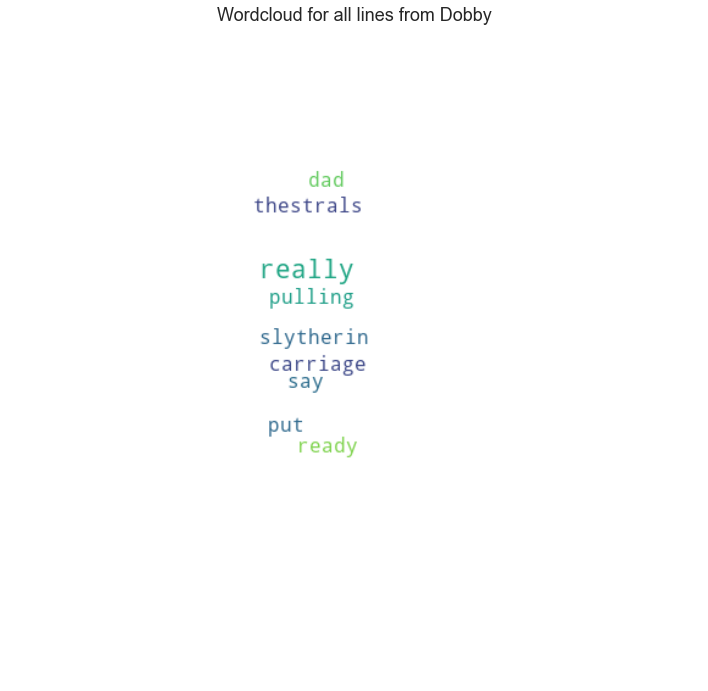

In [152]:
from os import path
from PIL import Image
import os

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
hp_mask = np.array(Image.open(path.join(d, "data/char_images/dobby.jpg")))

# Define the settings and input to the wordclouds - DC
wordcloud_all_books = WordCloud(background_color='white',   
                         width=1000,
                         max_words=2000,
                         height=1000, 
                         colormap="viridis",
                         mask = hp_mask,
                         random_state = 42
                         #contour_width=1, 
                         #contour_color='steelblue'
                        ).generate_from_frequencies(harry_freq)

plt.figure(figsize=(10,10))

plt.imshow(wordcloud_all_books, interpolation='bilinear')
plt.title("Wordcloud for all lines from Dobby", fontsize=18)
plt.axis("off")
plt.tight_layout()

In [125]:
df.head()

,movie_nr,sentence_number,character,sentence,scene_desc,scene_id,sentence_sent,scene_desc_sent,avg_scene_sent,avg_scene_desc_sent
0,1,1,dumbledore,I should have known that you would be here...P...,A neighbourhood on a street called Privet Driv...,1,5.740,5.740,5.506538,5.506538
1,1,2,mcgonagall,"Good evening, Professor Dumbledore. Are the ru...","The cat meows, sniffs out and the camera pans ...",1,6.685,6.685,5.506538,5.506538
2,1,3,dumbledore,"I'm afraid so, Professor. The good, and the bad.","The cat meows, sniffs out and the camera pans ...",1,4.635,4.635,5.506538,5.506538
3,1,4,mcgonagall,And the boy?,"The cat meows, sniffs out and the camera pans ...",1,6.240,6.240,5.506538,5.506538
4,1,5,dumbledore,Hagrid is bringing him.,"The cat meows, sniffs out and the camera pans ...",1,6.040,6.040,5.506538,5.506538


In [126]:
# function to plot moving average 

def m_avg(values,N): # takes in the values and the N of average (how many values to use)
    size = len(values)
    if size-N < 2:
        return(f'Short list or N too big.')
    else:
        cumsum, moving_aves = [0], []

        for i, x in enumerate(values, 1):
            cumsum.append(cumsum[i-1] + x)
            if i>=N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                
                # add the the average vector
                moving_aves.append(moving_ave)
    return(moving_aves)

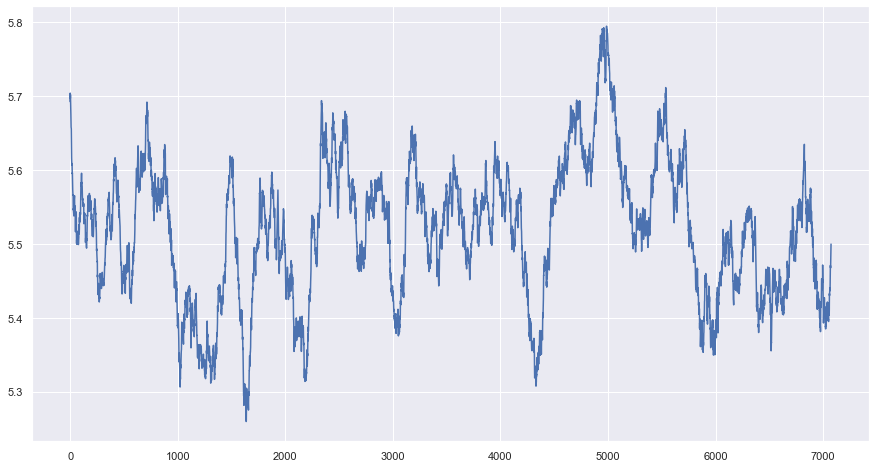

In [160]:
# m_avg(df.sent_sentence.dropna(),10)
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(m_avg(df.sentence_sent.dropna(),150))

In [166]:
df[df.character == 'harry']['sentence']

21                                     Yes, Aunt Petunia.
24                                     Yes, Uncle Vernon.
36                                           He's asleep!
38      Sorry about him. He doesn't understand what it...
39      Can you...hear me? {The snake nods} It's just....
                              ...                        
7969                       Because it answers to another.
7970    When he killed Snape, he thought the wand woul...
7971    It was Draco who disarmed Dumbledore that nigh...
7973                                    It answers to me.
7977                      Well, it wasn’t boring, was it?
Name: sentence, Length: 1995, dtype: object

In [238]:
df[df.character == 'sorting hat']

,movie_nr,sentence_number,character,sentence,scene_desc,scene_id,sentence_sent,scene_desc_sent,avg_scene_sent,avg_scene_desc_sent
1334,2,520,sorting hat,"Bee in your bonnet, Potter?",McGonagall marches Harry down to an UGLY STONE...,49,5.61,5.61,5.311329,5.311329
1336,2,522,sorting hat,If I put you in the right house? Yes... you we...,McGonagall marches Harry down to an UGLY STONE...,49,5.54,5.54,5.311329,5.311329
7895,8,791,sorting hat,"Don't despair, Longbottom. I put you in Gryffi...","The Sorting Hat. He ponders it, regarding its ...",80,5.15,5.15,5.555975,5.555975


In [249]:
df['character'][df.movie_nr == 1].value_counts()[:20].index.tolist() # get 20 most occuring characters 

harry potter        227
ron                 125
hermione             90
hagrid               85
mcgonagall           31
albus dumbledore     27
vernon               22
quirrell             19
dudley               18
neville              14
draco                14
hooch                13
petunia              13
snape                10
percy                 9
lee                   9
girl                  7
oliver                6
voldemort             6
filch                 5
Name: character, dtype: int64

In [247]:
df[df.character == 'nick']

,movie_nr,sentence_number,character,sentence,scene_desc,scene_id,sentence_sent,scene_desc_sent,avg_scene_sent,avg_scene_desc_sent
254,1,255,nick,Hello! How are you? Welcome to Gryffindor.,"Ron, having just finished a chicken wing, reac...",21,7.080000,7.080000,5.60133,5.60133
257,1,258,nick,"Dismal. Once again, my request to join the hea...","Numerous ghosts come pouring from the walls, s...",21,4.870000,4.870000,5.60133,5.60133
259,1,260,nick,I prefer Sir Nicholas if you don't mind.,"Numerous ghosts come pouring from the walls, s...",21,5.840000,5.840000,5.60133,5.60133
261,1,262,nick,Like this. {Grabs head and pulls it to the sid...,"Numerous ghosts come pouring from the walls, s...",21,5.407500,5.407500,5.60133,5.60133
339,1,340,nick,Have you heard? Harry Potter's the new Gryffin...,"Boy 2: Oh, that was wicked, Harry.",30,6.054286,6.054286,5.44075,5.44075


In [247]:
# Todo, finish up the moving average plot, set different colors on different movies
df[df.character ==  'aragog']['sentence']

1573    You do not come from the forest. Your hearts b...
1575    Hagrid has never sent men into our hollow before.
1577    That's a lie! Hagrid never opend the Chamber o...
1579    The monster was born in the castle. I came fro...
1582    We do not speak of it! It is an ancient creatu...
1584    I never saw any part of the castle but the cup...
1587    Go? I think not. My sons and daughters do not ...
2559    You do not come from the forest. Your hearts b...
2561    Hagrid has never sent men into our hollow before.
2563    That's a lie! Hagrid never opend the Chamber o...
2565    The monster was born in the castle. I came fro...
2568    We do not speak of it! It is an ancient creatu...
2570    I never saw any part of the castle but the cup...
2573    Go? I think not. My sons and daughters do not ...
Name: sentence, dtype: object

In [243]:
sentiments['die']

1.74